In [15]:
import pandas as pd, numpy as np
from pybedtools import BedTool
from collections import Counter
import matplotlib.pyplot as plt
from pandasql import sqldf
import os
path = os.path.expanduser("~/Documents/m6A/")
input_m6A_peak = f"{path}/Data/metApeakFisher/unmerged_peaks_metApeak.bed"
input_m6A_nonpeak = f"{path}/Data/metApeakFisher/unmerged_nonpeaks_metApeak.bed"
input_RBP = f"{path}/Data/all.RBP.intersect.hg19.bed"
input_intersect_peak = f"{path}/Data/metApeakFisher/peak.intersect.RBP.bed"
input_intersect_nonpeak = f"{path}/Data/metApeakFisher/nonpeak.intersect.RBP.bed"

### m6A peaks and nonpeaks

In [2]:
m6A_peaks = pd.read_table(input_m6A_peak, header = 0)
m6A_peaks = m6A_peaks.sort_values(by = ["# chr", "chromStart"])
m6A_peaks = m6A_peaks.rename(columns = {"# chr": "chr"})
# m6A_peaks = m6A_peaks[m6A_peaks["score"] < 0.05]

In [3]:
m6A_nonpeaks = pd.read_table(input_m6A_nonpeak, header = 0)
m6A_nonpeaks = m6A_nonpeaks.sort_values(by = ["# chr", "chromStart"])
m6A_nonpeaks = m6A_nonpeaks.rename(columns = {"# chr": "chr"})
# m6A_nonpeaks = m6A_nonpeaks.sort_values(by = ["score"], ascending = False)
# m6A_nonpeaks = m6A_nonpeaks.iloc[:10000, :]

In [4]:
print (m6A_peaks.shape, m6A_nonpeaks.shape)

(184390, 12) (282904, 12)


In [5]:
peak_name = set(m6A_peaks["name"])
nonpeak_name = set(m6A_nonpeaks["name"])
uniq_peak_name = [name for name in peak_name if name not in nonpeak_name]
uniq_nonpeak_name = [name for name in nonpeak_name if name not in peak_name]
intersect_name = list(set(m6A_peaks["name"]) & set(m6A_nonpeaks["name"]))
union_name = list(set(m6A_peaks["name"]) | set(m6A_nonpeaks["name"]))

In [6]:
len(uniq_peak_name), len(uniq_nonpeak_name), len(intersect_name), len(union_name)

(108, 14377, 10633, 25118)

### RBP binding sites

In [7]:
RBP_binding_sites = pd.read_table(input_RBP, sep="\t", header = None, 
                                  names = ["chr", "start", "end", "RBP", "peak_width", "strand"])
RBP_binding_sites = RBP_binding_sites[RBP_binding_sites["peak_width"] <= 200]
RBP_name = set(RBP_binding_sites["RBP"])
RBP_peak_uniq = RBP_name.intersection(peak_name)
RBP_nonpeak_uniq = RBP_name.intersection(nonpeak_name)
RBP_name = list(RBP_name)
RBP_name.sort()

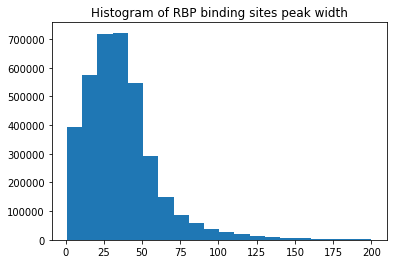

In [8]:
peak_width = RBP_binding_sites["peak_width"].tolist()
plt.hist(peak_width, bins = 20)  # arguments are passed to np.histogram
plt.title("Histogram of RBP binding sites peak width")
plt.show()

### Use "bedtools" in bash
sort -k1,1 -k2,2n unmerged_peaks_metApeak.bed > peaks.bed

sort -k1,1 -k2,2n unmerged_nonpeaks_metApeak.bed > nonpeaks.bed

bedtools intersect -a ../all.RBP.intersect.hg19.bed -b peaks.bed -s > peak.intersect.RBP.bed

bedtools intersect -a ../all.RBP.intersect.hg19.bed -b nonpeaks.bed -s > nonpeak.intersect.RBP.bed

In [27]:
peaks_intersect = pd.read_table(input_intersect_peak, header = None, 
                                names = ["chr", "chromStart", "chromEnd", "name", "inter_width", "strand"])

In [28]:
nonpeaks_intersect = pd.read_table(input_intersect_nonpeak, header = None, 
                                   names = ["chr", "chromStart", "chromEnd", "name", "inter_width", "strand"])

In [31]:
peaks_intersect.head(15)
# count 

,chr,chromStart,chromEnd,name,inter_width,strand
0,chr1,990435,990460,AGGF1,26,+
1,chr1,2162434,2162448,AGGF1,15,+
2,chr1,2171771,2171796,AGGF1,26,+
3,chr1,2171949,2171994,AGGF1,46,+
4,chr1,2173426,2173427,AGGF1,2,+
5,chr1,2209376,2209470,AGGF1,95,+
6,chr1,11083600,11083631,AGGF1,32,+
7,chr1,12003378,12003400,AGGF1,23,+
8,chr1,12004523,12004544,AGGF1,22,+
9,chr1,16174399,16174434,AGGF1,47,+


In [11]:
# # where RBP name and gene name are the same 
# m6A_RBP = pd.DataFrame()
# for name in RBP_name:
#     m6A_peaks_data = m6A_peaks[m6A_peaks["name"] == name]
#     m6A_nonpeaks_data = m6A_nonpeaks[m6A_nonpeaks["name"] == name]
#     RBP_binding_sites_data = RBP_binding_sites[(RBP_binding_sites["name"] == name)]
#     data = dict([("peak", "m6A_peaks_data"), ("nonpeak", "m6A_nonpeaks_data"), ("RBP", "RBP_binding_sites_data")])
#     for idx in ["peak", "nonpeak"]:
#         query = """
#             SELECT peaks.chr, peaks.chromStart, peaks.chromEnd, peaks.name, peaks.score, peaks.blockSizes, peaks.blockCount, rbp.start, rbp.end, rbp.peak_width, rbp.strand
#             FROM {} peaks LEFT JOIN {} rbp
#             WHERE peaks.chr == rbp.chr AND peaks.strand == rbp.strand
#             AND (
#             (rbp.start >= peaks.chromStart AND rbp.start <= peaks.chromEnd)
#             OR
#             (rbp.end >= peaks.chromStart AND rbp.end <= peaks.chromEnd)
#             OR
#             (rbp.start <= peaks.chromStart AND rbp.end >= peaks.chromEnd)
#             )
#         """.format(data[idx], data["RBP"])
#         intersect = sqldf(query)
#         intersect["m6A_peak_index"] = idx
#         m6A_RBP = m6A_RBP.append(intersect)

# m6A_RBP = m6A_RBP.rename(columns = {"start": "RBP_start", "end": "RBP_end", "peak_width": "RBP_peak_width"})
# writer = pd.ExcelWriter(f"{path}/output/RBP_m6A_intersection.xlsx")
# m6A_RBP.sort_values(by = ["name"]).set_index(["name", "m6A_peak_index"]).to_excel(writer, 'Sheet1')
# writer.save()

In [11]:
RBP_eg = ["HNRNPC", "FTO"]
for name in RBP_eg:
    m6A_RBP = pd.DataFrame()
    RBP_binding_sites_data = RBP_binding_sites[(RBP_binding_sites["RBP"] == name)]
    data = dict([("peak", "m6A_peaks"), ("nonpeak", "m6A_nonpeaks"), ("RBP", "RBP_binding_sites_data")])
    for idx in ["peak", "nonpeak"]:
        query = """
            SELECT peaks.chr, peaks.name, peaks.chromStart, peaks.chromEnd, peaks.score, peaks.blockSizes, peaks.blockCount, rbp.RBP, rbp.start, rbp.end, rbp.peak_width, rbp.strand
            FROM {} peaks LEFT JOIN {} rbp
            WHERE peaks.chr == rbp.chr AND peaks.strand == rbp.strand
            AND (
            (rbp.start >= peaks.chromStart AND rbp.start <= peaks.chromEnd)
            OR
            (rbp.end >= peaks.chromStart AND rbp.end <= peaks.chromEnd)
            OR
            (rbp.start <= peaks.chromStart AND rbp.end >= peaks.chromEnd)
            )
        """.format(data[idx], data["RBP"])
        intersect = sqldf(query)
        intersect["m6A_peak_index"] = idx
        m6A_RBP = m6A_RBP.append(intersect)
    writer = pd.ExcelWriter(f"{path}/output/{name}.xlsx")
    m6A_RBP.sort_values(by = ["chr", "name", "m6A_peak_index"]).set_index(["RBP", "m6A_peak_index"]).to_excel(writer, 'Sheet1')
    writer.save()

### Check whether RBP binding sites are more common in m6A sites

In [9]:
query = """
    SELECT peaks.chr, peaks.chromStart, peaks.chromEnd, peaks.name, peaks.score, rbp.chr, rbp.start, rbp.end, rbp.RBP, rbp.peak_width, rbp.strand
    FROM {} peaks LEFT JOIN RBP_binding_sites rbp
    WHERE peaks.chr == {} AND rbp.chr == {}
    AND (
    (rbp.start >= peaks.chromStart AND rbp.start <= peaks.chromEnd)
    OR
    (rbp.end >= peaks.chromStart AND rbp.end <= peaks.chromEnd)
    OR
    (rbp.start <= peaks.chromStart AND rbp.end >= peaks.chromEnd)
    )
""".format("m6A_peaks", "'chrY'", "'chrY'")

In [10]:
peaks_Y = sqldf(query)

In [11]:
peaks_Y

,chr,chromStart,chromEnd,name,score,chr,start,end,RBP,peak_width,strand
0,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710203,2710241,BCCIP,39,+
1,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710205,2710239,GRWD1,35,+
2,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710205,2710246,EIF3D,42,+
3,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710205,2710276,EIF3H,72,+
4,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710235,2710253,NOL12,19,+
5,chrY,2712118,2712168,RPS4Y1,0.64,chrY,2712126,2712133,EIF3H,8,+
6,chrY,2712118,2712168,RPS4Y1,0.64,chrY,2712132,2712143,GRWD1,12,+
7,chrY,2712118,2712168,RPS4Y1,0.64,chrY,2712165,2712298,GRWD1,134,+
8,chrY,2722661,2722711,RPS4Y1,0.56,chrY,2722666,2722696,GRWD1,31,+
9,chrY,2722661,2722711,RPS4Y1,0.56,chrY,2722669,2722704,SRSF9,36,+


In [34]:
query_non_peaks = """
    SELECT nonpeaks.chr, nonpeaks.chromStart, nonpeaks.chromEnd, nonpeaks.name, nonpeaks.score, rbp.chr, rbp.start, rbp.end, rbp.RBP, rbp.peak_width, rbp.strand
    FROM {} nonpeaks LEFT JOIN RBP_binding_sites rbp
    WHERE nonpeaks.chr == {} AND rbp.chr == {}
    AND (
    (rbp.start >= nonpeaks.chromStart AND rbp.start <= nonpeaks.chromEnd)
    OR
    (rbp.end >= nonpeaks.chromStart AND rbp.end <= nonpeaks.chromEnd)
    OR
    (rbp.start <= nonpeaks.chromStart AND rbp.end >= nonpeaks.chromEnd)
    )
""".format("m6A_nonpeaks", "'chrY'", "'chrY'")

In [35]:
non_peaks_Y = sqldf(query_non_peaks)

In [36]:
non_peaks_Y

,chr,chromStart,chromEnd,name,score,chr,start,end,RBP,peak_width,strand
0,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722770,2722813,PPIG,44,+
1,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722777,2722813,GRWD1,37,+
2,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722797,2722802,GRSF1,6,+
3,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722799,2722812,EIF3D,14,+
4,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2722770,2722813,PPIG,44,+
5,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2722777,2722813,GRWD1,37,+
6,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2722799,2722812,EIF3D,14,+
7,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2723142,2723170,SUGP2,29,+
8,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2723442,2723472,CDC40,31,+
9,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2723445,2723507,SUGP2,63,+


In [49]:
common_RBP = [name for name in set(m6A_peaks["name"]) if name in set(m6A_nonpeaks["name"])]